# TO RUN : importS

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import bz2
import urllib
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nltk
import ssl
from scipy import stats
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sns.set(font_scale = 1.3, rc = {'figure.figsize':(10,6)})
sns.set_palette('colorblind')
data_folder = 'data/'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arthurdietrich/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1- FIRST STATISTICS
Here, we try to extract a few basic statistics to make sure we have the necessary data to perform the project. Indeed, after selecting the quotations of interests (the ones related to arms in the USA), we want to make sure these datas are sufficiently numerous to perform an actual study on the right to bear arms in the USA. We also want to check if our research questions are reasonnnable and can be solved from our data. <br>
<br>
First, we get a sense of the quantity of actual quotations speaking about arms, and we compute its share in the total quotes dataset of 2017.

### Load the data
The new dataset `quotes-2017-extended.json` can be loaded from here.

In [2]:
gunquotes = pd.read_json('data/quotes-2017-extended.json.bz2', lines=True, compression='bz2')
gunquotes

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,nationality,occupation,age,ethnic_group,party,religion
0,2017-03-26-000661,"A big burglar, I never really knew him to carr...",Brian Andrews,"[Q2924842, Q4962982, Q4962983]",2017-03-26 17:01:19,1,"[[Brian Andrews, 0.7167], [Tony Fiore, 0.1666]...",[http://www.providencejournal.com/news/2017032...,E,male,[United States of America],[singer],41.0,None,None,None
1,2017-05-22-015293,"Congress, investigate Seth Rich Murder! @ Juli...",Sean Hannity,[Q557730],2017-05-22 14:40:47,3,"[[Sean Hannity, 0.8718], [None, 0.0946], [Kim ...",[http://news.yahoo.com/news/seth-rich-conspira...,E,male,[United States of America],"[radio personality, television presenter, jour...",59.0,None,[Conservative Party of New York State],[Catholicism]
2,2017-09-11-088873,similar rules for whether you can own a gun an...,Kris Kobach,[Q6437211],2017-09-11 22:17:52,2,"[[Kris Kobach, 0.5138], [John Lott, 0.3198], [...",[http://www.kansas.com/news/politics-governmen...,E,male,[United States of America],[lawyer],55.0,None,[Republican Party],None
3,2017-08-10-034688,He keeps getting better each day at practice. ...,Ruffin McNeill,[Q7377923],2017-08-10 01:00:45,1,"[[Ruffin McNeill, 0.7703], [None, 0.2297]]",[http://newsok.com/marquise-overton-expected-t...,E,male,[United States of America],"[head coach, American football player]",63.0,None,None,None
4,2017-11-19-055725,The easiest one is to make guns better for hom...,David Hemenway,[Q1107796],2017-11-19 14:50:20,1,"[[David Hemenway, 0.791], [None, 0.209]]",[http://www.wbur.org/npr/462252799/research-su...,E,male,[United States of America],"[economist, university teacher]",76.0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36457,2017-10-04-005756,All things that make America safer and don't i...,Lindsey Graham,[Q22212],2017-10-04 21:19:20,1,"[[Lindsey Graham, 0.8846], [None, 0.1154]]",[http://www.wandtv.com/story/36523093/congress...,E,male,[United States of America],"[politician, air force officer, lawyer, county...",66.0,None,[Republican Party],[Southern Baptist Convention]
36458,2017-10-02-005046,already this year there have been more mass sh...,Chris Murphy,"[Q1077594, Q20022484, Q2964809, Q5107535, Q510...",2017-10-02 15:00:00,2,"[[Chris Murphy, 0.8709], [None, 0.12], [Elizab...",[http://commondreams.org/news/2017/10/02/messa...,E,male,[United States of America],"[politician, lawyer]",48.0,[Irish people],[Democratic Party],[Protestantism]
36459,2017-06-03-012435,"Evolution is also the basis of racism, [ and ]...",David Whitney,[Q215478],2017-06-03 00:00:00,3,"[[David Whitney, 0.6764], [None, 0.3236]]",[http://www.patheos.com/blogs/friendlyatheist/...,E,male,[United States of America],"[screenwriter, film director, film producer, j...",77.0,None,None,None
36460,2017-08-29-047666,I t's a movie about growing up and about gener...,Don Hahn,"[Q1072843, Q5292728]",2017-08-29 18:10:00,2,"[[Don Hahn, 0.8057], [None, 0.1943]]",[http://hellogiggles.com/reviews-coverage/movi...,E,male,[United States of America],"[film producer, screenwriter, film director, a...",65.0,None,None,None


In [3]:
nblines_gunquotes = gunquotes.shape[0]
nbtot_gunquotes = gunquotes['numOccurrences'].sum()
print(nblines_gunquotes)
print(nbtot_gunquotes)

36462
212199


In [ ]:
share_gunquotes = 100 * nblines_gunquotes / nblines_totquotes
sharetot_gunquotes = 100 * nbtot_gunquotes / nbtot_totquotes
print(share_gunquotes)
print(sharetot_gunquotes)

**Analysis :** <br>
The new dataset (with only selected quotes) contain 36462 different quotes, some of which are quoted in several articles. Thus, there is a total number of 212199 quotes found in the 2017 newspapers that are related to our topic. <br>
This represent a share of     % of the total quotations of 2017. Even if this share is very small, the size of the original 2017 dataset being very huge, it is not surprising and 36462 different quotations is already quite a lot of data for 1 year for our project.

### A first timeline for 2017

In [4]:
# Useful functions for the following plots

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

#### 'Gun quotes' timeline per month

dateWithoutTime
1       591
2      4222
3     12014
4     16151
5     12107
6     43104
7     13109
8     16648
9     11135
10    41903
11    27478
12    13737
Name: numOccurrences, dtype: int64
212199


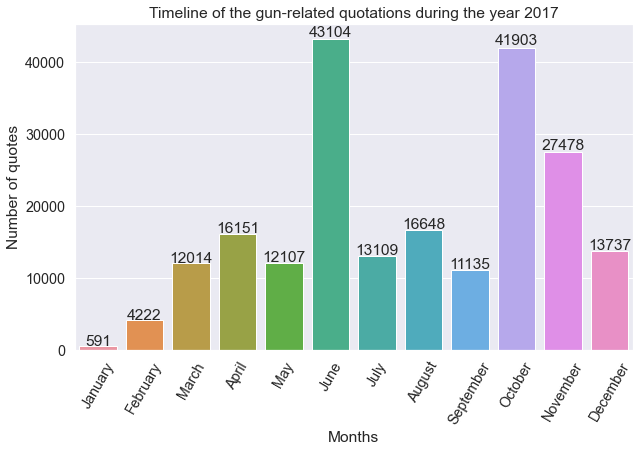

In [6]:
## Plot of the nb of quotes related to guns in function of the month

gunquotes['dateWithoutTime'] = gunquotes['date'].dt.normalize()

quotes_perMonth = gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum()
print(quotes_perMonth)
print(quotes_perMonth.sum())
# ax = sns.barplot(x=gunquotes.groupby(gunquotes["dateWithoutTime"].dt.month), y=gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum())#, data=gunquotes)
ax = sns.barplot(x=np.linspace(1,12,12), y=gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum())#, data=gunquotes)
# ax = sns.barplot(x=quotes_perMonth.index, y=quotes_perMonth)
sns.set_color_codes("colorblind")
ax.set_xlabel('Months')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
ax.set_xticklabels(labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=60)
show_values(ax)
plt.show()


**Analysis :** <br>
The barplot reveals an unexpected big amount of quotations speaking about guns in the months of June and October. One can guess that this is due to an event that occured in this month. Indeed, for example the amounts of quotes in October can be explianed by the Las Vegas shooting of the 1st of October. To verfiy this guess we will look further at the distribution of the quotes in thess 2 months.

#### Zoom on the month of June

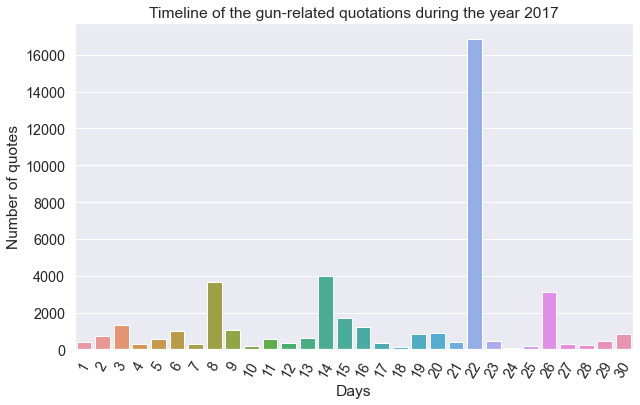

In [12]:
## Plot of the nb of quotes related to guns in function of the date : zoom on JUNE

june = gunquotes[(gunquotes['date'].dt.month == 6)]

ax = sns.barplot(x=np.linspace(1,30,30, dtype='int'), y=june.groupby(june['dateWithoutTime']).numOccurrences.sum())#, data=gunquotes)
sns.color_palette("tab10")
ax.set_xlabel('Days')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
plt.xticks(rotation=60)
# show_values(ax)
plt.show()

## Explanation :
## https://www.nytimes.com/2017/06/26/us/politics/supreme-court-guns-public-california.html
## https://www.pewresearch.org/social-trends/2017/06/22/americas-complex-relationship-with-guns/
## Fusillade de l'entrainement républicain du match de baseball du Congrès le 14 juin 2017 : https://fr.wikipedia.org/wiki/Fusillade_de_l%27entrainement_r%C3%A9publicain_du_match_de_baseball_du_Congr%C3%A8s
## Pizzagate shooters sentenced to 4 years of prison on the 22th of June 2017 : https://edition.cnn.com/2017/06/22/politics/pizzagate-sentencing/index.html

In [15]:
gunquotes[(gunquotes['date'].dt.month == 6)]
june[(june['date'].dt.day==22)].numOccurrences.sum()
june[(june['date'].dt.day!=22)].numOccurrences.mean()

7.603768115942029

In [57]:
june_22 = june[(june['date'].dt.day==22)]
june_22.quotation.iloc[1]
# june_22[(june_22.quotation.str.contains('pedophilia'))].numOccurrences.sum()
june[(june.quotation.str.contains('sentenced'))].quotation
# june_22[(june_22.quotation.str.contains('prison'))].numOccurrences.sum()
gunquotes[(gunquotes.quotation.str.contains('Last month, Joshua Brandon Vallum'))]
# gunquotes.iloc[19414].quotation
# gunquotes.iloc[31416].urls
# june[(june.quotation.str.contains('baseball'))].numOccurrences.sum()
# june[(june.quotation.str.contains('baseball'))].iloc[0].quotation

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,nationality,occupation,age,ethnic_group,party,religion,dateWithoutTime
8250,2017-10-16-136588,We have and will continue to enforce hate crim...,Jeff Sessions,[Q358443],2017-10-16 18:55:01,1,"[[Jeff Sessions, 0.9109], [None, 0.0891]]",[http://freebeacon.com/issues/sessions-sends-f...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-10-16
19414,2017-06-30-066125,"Last month, Joshua Brandon Vallum was sentence...",Jeff Sessions,[Q358443],2017-06-30 15:14:28,1,"[[Jeff Sessions, 0.635], [None, 0.365]]",[http://www.newnownext.com/jeff-sessions-enfor...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-06-30
23347,2017-06-29-131630,We have and will continue to enforce hate crim...,Jeff Sessions,[Q358443],2017-06-29 15:59:46,2,"[[Jeff Sessions, 0.8184], [None, 0.1816]]",[http://freebeacon.com/issues/sessions-address...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-06-29
31416,2017-06-29-071546,"Last month, Joshua Brandon Vallum was sentence...",Jeff Sessions,[Q358443],2017-06-29 20:17:00,4,"[[Jeff Sessions, 0.7653], [None, 0.2128], [Pre...",[http://www.christianpost.com/news/trump-justi...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-06-29


**Analysis :**  
The timeline for June is quite interesting. There is a big peak in the quantity of quotes for the day 22 : 16 871 quotes published in the newspapers, while the other days have a mean of approximately 8 quotes. We were quite supprised by this result as we didn't remember of any event related to guns in this period. After a few reaserch on the web, we found that the 22th of June 2017 corresponds to the day that the 'Pizzagate' murderer (4th December 2016) was sentenced to 4 years of prison. We think that the big amount of quotes for this day, is indeed related to this sentence since a lot of these quotation contains key words about this topic.  
Sources : https://www.nytimes.com/2017/06/22/us/pizzagate-attack-sentence.html ; https://en.wikipedia.org/wiki/Pizzagate_conspiracy_theory   

There was also a shooting during a baseball practice of the Congressional Baseball Game for Charity on the 14th of June 2017. This explains the also quite large amount of data for this day and the large amount of quotations (201) containing the word *"baseball"*.  
Source : https://en.wikipedia.org/wiki/Congressional_baseball_shooting

#### Zoom on the month of October

In [3]:
## Plot of the nb of quotes related to guns in function of the date : zoom on OCTOBER

october = gunquotes[(gunquotes['date'].dt.month == 10)]
# nb = october.groupby(october['dateWithoutTime']).numOccurrences.sum()
# print(nb.sum())

ax = sns.barplot(x=np.linspace(1,31,31, dtype='int'), y=october.groupby(october['dateWithoutTime']).numOccurrences.sum())#, data=gunquotes)
sns.color_palette("tab10")
ax.set_xlabel('Days')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
#ax.set_xticklabels(labels=labs)
plt.xticks(rotation=60)
show_values(ax)
plt.show()

## Explanation : Las Vegas shooting on the 1st of October 2017

KeyError: 'dateWithoutTime'

**Analysis :**  
Most of the quotations of the month of October were found in articles of the 2nd of October, the day after the mass shooting of Las Vegas. This thus confirms our guess that these articles spoke about this event. The following days, also show a higher amount of quotations, revealing that the medias continued to talk about the tragedy in the following days.

# 2- MATCHING OF THE DATASET FOR SENTIMENT ANALYSIS

### Matching of the dataset 

One idea of our project is to try to link the membership of a speaker to a political party and its opinion, sentiment about the gun control. However, we can't just apply a sentiment analysis on each quotes and make a statistical test to determine which party is the most favorable to the right of carrying a gun. Indeed, we must first balanced our dataset by matching to be sure that we got equivalent distributions of each class. For this milestone, we choose the treated group to be the Democratic Party and the control group the Republican Party. We balanced these groups depending on the gender and the age of the speakers.


First, we need to clean our dataset to remove the rows without political party or with a non-realistic age. We have encountered a problem for the choice of the political party from WikiData. Indeed, some speakers have been members of multiple parties during their life and so, have mulitple parties on WikiData. However, there isn't a systematic chronological order for the political parties so we chose to keep the first party for each speaker.We check manually for a lot of speaker and in a very large part of the cases this choice was accurate.

Then, we print the number of occurences for each party and as expected, the Democratic Party and the Republican Party are by far the most represented so we choose to keep only these rows.

In [225]:
def clean_df(df):
    df = df.loc[df['party'].notna()].copy() #remove the rows without political party
    df = df.loc[(df['age']>10)&(df['age']<110)&(df['age'].notna())].copy() #remove the rows without age or with a non-realistic age

    df.party = df.party.str[0] # keep only the first party         
        
    print(df['party'].value_counts()) # this print shows the occurances of each party
                                      # as expected, the Republican party and the Democratic party are the most represented
        
    df.loc[df['party'].str.contains('Democratic'), 'party'] = 'Democratic'
    df.loc[df['party'].str.contains('Republican'), 'party'] = 'Republican'
    df = df.loc[(df['party'].str.contains('Democratic')) | \
                df['party'].str.contains('Republican')].copy() # convert the "local" parties into "national" parties :
                                                               # "California Republican Party" --> "Republican Party"
    
    df.reset_index(inplace = True, drop = True)
    return df

In [226]:
gunquotes_clean = clean_df(gunquotes)

Republican Party                                    7748
Democratic Party                                    6195
independent politician                               147
Minnesota Democratic–Farmer–Labor Party              101
Liberty Union Party                                   65
Peace and Freedom Party                               60
Conservative Party of New York State                  59
Libertarian Party                                     44
California Republican Party                           42
California Democratic Party                           31
Republican Party of Iowa                              31
Conservative Party                                    30
Nebraska Democratic Party                             29
Republican Party of Minnesota                         23
Iowa Democratic Party                                 13
Likud                                                 13
Republican Party of Arkansas                          11
Labour Party                   

Now, we can plot the distribution of the two categories (gender and age) among the two groups (Democratic and Republican Parties).

Text(0.5, 0, 'group')

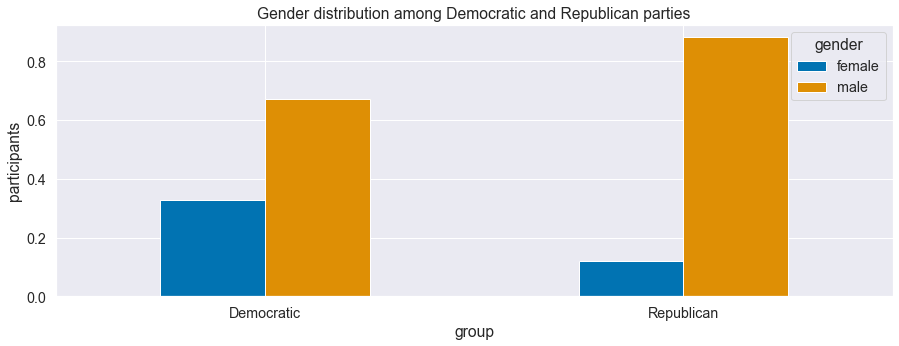

In [228]:
group = gunquotes_clean.groupby(['party', 'gender'])['gender'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[15,5], rot=0)
pl.set_title('Gender distribution among Democratic and Republican parties')
pl.set_ylabel('participants')
pl.set_xlabel('group')

Text(0.5, 1.0, 'Age distribution among Democratic and Republican Parties')

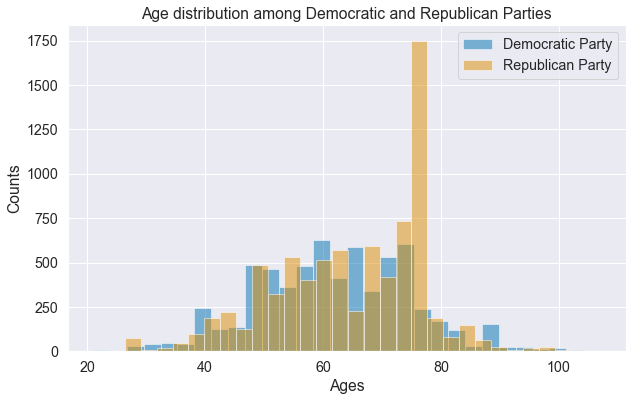

In [229]:
rep_age = gunquotes_clean.age[gunquotes_clean['party']=='Republican']
dem_age = gunquotes_clean.age[gunquotes_clean['party']=='Democratic']
plt.hist(dem_age, alpha = 0.5, label = 'Democratic Party', bins = 30)
plt.hist(rep_age, alpha = 0.5, label = 'Republican Party', bins = 30)
plt.legend()
plt.xlabel('Ages')
plt.ylabel('Counts')
plt.title('Age distribution among Democratic and Republican Parties')

We can observe that the gender class isn't distributed in the same way between the two parties. As expected, the proportion of woman in the Democratic Party is much more important that in the Republican Party. We can also observe that the age distribution is globally the same for the two parties except for one difference : the presence of a huge peak around 75 years old among the Republican Party. As expected, we need to operate a matching to balanced our dataset.

In [276]:
def logreg(df): # We use a logistic regression to compute the propensity code
    
    # We add a "male" column with 1 if the speaker is a male and 0 if not
    # We do the same for the party column with the Republican party
    
    male_republican = pd.get_dummies(df[['party','gender']],columns = ['gender','party'], drop_first=True) 
    df = df.join(male_republican)
    df.rename(columns={"party_Republican": "Republican", "gender_male": "male"}, inplace = True)
    df['age_norm'] = (df['age'] - df['age'].mean())/df['age'].std() #Standardization of the age
    mod = smf.logit(formula='Republican ~  C(male) + age_norm', data=df)

    res = mod.fit()

    # Extract the estimated propensity scores
    df['Propensity_score'] = res.predict()
    print(res.summary())

    return df

In [173]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [174]:
def matching(df):
    # Separate the treatment and control groups
    treatment_df = df[df['Republican'] == 1]
    control_df = df[df['Republican'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            if(control_row['male']==treatment_row['male']):
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])
            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.iloc[matched]
    return balanced_df

In [250]:
def process_df(df):
    df = logreg(df)
    balanced_df = matching(df)
    return balanced_df.reset_index(drop = True)

For this milestone, we choose to limitate the matching for a subset of our dataset because the execution time of this operation grows exponentially with the number of individuals. For the next milestone, we need to find a way to do it on the full dataset (using Google collab for example).

In [277]:
gunquotes_balanced = process_df(gunquotes_clean[:1000])

Optimization terminated successfully.
         Current function value: 0.634972
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             Republican   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                 0.08086
Time:                        16:58:33   Log-Likelihood:                -634.97
converged:                       True   LL-Null:                       -690.83
Covariance Type:            nonrobust   LLR p-value:                 5.493e-25
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1015      0.153     -7.182      0.000      -1.402      -0.801
C(male)[T.1]     1.5945

Text(0.5, 0, 'group')

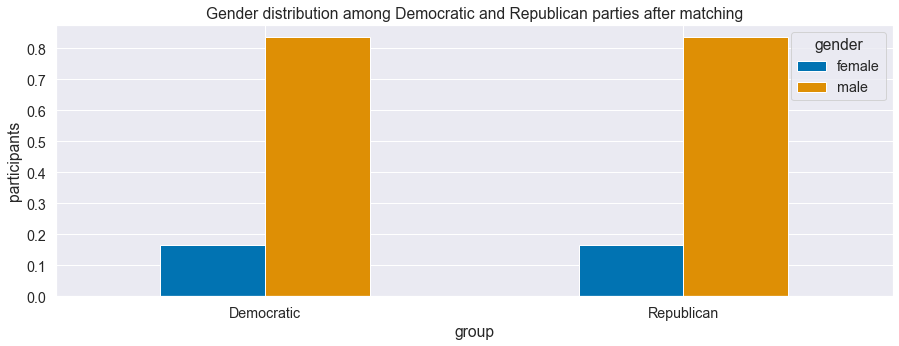

In [278]:
group = gunquotes_balanced.groupby(['party', 'gender'])['gender'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[15,5], rot=0)
pl.set_title('Gender distribution among Democratic and Republican parties after matching')
pl.set_ylabel('participants')
pl.set_xlabel('group')

Text(0.5, 1.0, 'Sentiment analysis about gun quotes for each political party')

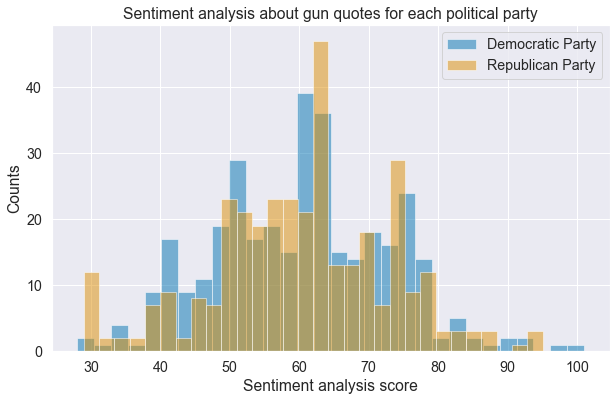

In [279]:
rep_age = gunquotes_balanced.age[gunquotes_balanced['party']=='Republican']
dem_age = gunquotes_balanced.age[gunquotes_balanced['party']=='Democratic']
plt.hist(dem_age, alpha = 0.5, label = 'Democratic Party', bins = 30)
plt.hist(rep_age, alpha = 0.5, label = 'Republican Party', bins = 30)
plt.legend()
plt.xlabel('Sentiment analysis score')
plt.ylabel('Counts')
plt.title('Sentiment analysis about gun quotes for each political party')

After the matching, the distribution of the two classes (gender and age) in each groups (Democratic and Republicans parties) are better distribuated. The proportion of women in each groups are now the same and we manage to remove the peak at 75 years old in the Republican Party.

### Sentiment analysis

In order to relate the social caracteristics of speakers to their opinion on the right to own guns, we have to perform a sentiment analysis on the citations in order to extract a score for each citation. We use the compound score which is between -1 and 1. A score close to -1 indicates that the quotation speaks negatively (e.g. 'The gun owning is the a curse for the US' has a compound score of -0.7096). A score close to 1 indicates that the quotation speaks positively (e.g. 'The 2nd amendment is the best part of the constitution' has a compound score of 0.6369). A score of 0 indicates neutrality of the quotation. To do so, we use the VADER-Sentiment-Analysis library which contains a pretrained model to score a sentence.

In [168]:
def sentiment_analysis(df):
    sid = SentimentIntensityAnalyzer()
    df['sentiment'] = df.quotation.apply(sid.polarity_scores)
    df['sentiment'] = df.sentiment.apply(dict.values)
    df['sentiment'] = df.sentiment.apply(list)
    df['sentiment'] = df.sentiment.str[-1]
    return df

In [169]:
gunquotes_balanced = sentiment_analysis(gunquotes_balanced)

Democratic Party:
 count    345.000000
mean      -0.313857
std        0.521631
min       -0.975000
25%       -0.758200
50%       -0.421500
75%        0.025800
max        0.926000
Name: sentiment, dtype: float64
Republican_Party:
 count    345.000000
mean      -0.228355
std        0.568630
min       -0.992800
25%       -0.751200
50%       -0.340000
75%        0.177900
max        0.981700
Name: sentiment, dtype: float64


Text(0.5, 1.0, 'Sentiment analysis about gun quotes for each political party')

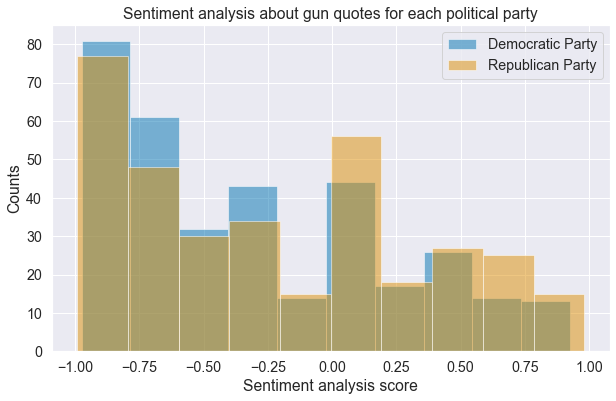

In [170]:
rep_sent = gunquotes_balanced.sentiment[gunquotes_balanced['party']=='Republican']
dem_sent = gunquotes_balanced.sentiment[gunquotes_balanced['party']=='Democratic']
print('Democratic Party:\n',dem_sent.describe())
print('Republican_Party:\n',rep_sent.describe())
plt.hist(dem_sent, alpha = 0.5, label = 'Democratic Party')
plt.hist(rep_sent, alpha = 0.5, label = 'Republican Party')
plt.legend()
plt.xlabel('Sentiment analysis score')
plt.ylabel('Counts')
plt.title('Sentiment analysis about gun quotes for each political party')

From the distributions of the results of the sentiment anlaysis and their basic statistics, it seems that The Democrats are moke likely to speak badly of guns than Republicans. However, we need to do a statistical test to confirm this hypothesis. 

In [179]:
stats.ttest_ind(rep_sent, dem_sent)

Ttest_indResult(statistic=2.058111249267868, pvalue=0.039955586466430784)

As the p-value is smaller than 0.05, we can reject the hyothesis that the two groups have the same mean. This lead us to conclude that indeed, Democrats tend to speak more badly about guns than Republicans. 

# Conclusions on the following of the project  
TO COMPLETE